In [1595]:
import pandas as pd
import json
import re
import ast
import matplotlib.pyplot as plt
import numpy as np

In [1596]:
DATA_FILE_PATH = "./EarthCam_DataScience_Data.csv"
data = pd.read_csv(DATA_FILE_PATH)

# EarthCam

In [1597]:
data.columns

Index(['ObservedAt', 'ObservedAt_DateTime', 'Station', 'Record', 'ID',
       'datetime', 'Temperature', 'Dewpoint', 'FeelsLike', 'HeatIndex',
       'Windchill', 'Pressure', 'Precipitation', 'Wind', 'RelativeHumidity',
       'CurrentConditions', 'CurrentConditionsAbbreviation', 'ConditionType',
       'CloudCondition', 'CloudReport', 'Visibility', 'Clouds', 'Lightning',
       'SunInfo', 'MoonInfo', 'raw', 'daily_total_precipitation'],
      dtype='object')

In [1598]:
data['daily_total_precipitation'].isna().sum()

7324

In [1599]:
data.shape

(7324, 27)

### At first glance this will be a simple time series problem. 

    Which means that we have a few steps to take care of before modeling : 
        First we should take a look at the data that we can, what types are they and how can we massage them into a usable format?
        What is the label value that we are using for the data?  What problem does this solve?
        After, let's peak at the missing values, NaN's in the data might be dealt with by imputation and Nan's within the labels might be dropped, iff they are first or last.
        EDA : Let's make some graphs and take a look at what is really going on in the data.  FFT.  Seasonality charts.

    We also have a single out of place column : daily_total_precipitation
        This is most likely the label, but let's save the judgement until later seeing that Precipitation exists as a column.

    That's a good enough plan for now, when we know more about the data we can extend this plan later in the document.


In [1600]:
data_simple_numeric = data.describe().columns
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ObservedAt,7324.0,1.604284e+09,4.568133e+07,1.525172e+09,1.564306e+09,1.604761e+09,1.643700e+09,1.683260e+09
ID,7324.0,4.054300e+08,1.026939e+08,2.201608e+08,3.141024e+08,4.126742e+08,5.076364e+08,5.530488e+08
RelativeHumidity,7324.0,7.371176e-01,1.898096e-01,1.410000e-01,5.970000e-01,7.580000e-01,8.860000e-01,1.000000e+00
daily_total_precipitation,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1601]:
quickly_availble_data = data[data_simple_numeric]

We have a few varaibles here that are useful : 

    RealativeHumidity, and it seems like there are values here that are usful.
    ID is a value that we can get rid of here but let's save that until the end.
    ObservedAt, this could be a usful varaible for out series, could be converted to timestamp.
    Let's also note that daily_total_precipitation has NaN values.  Some cleaning is required but we should find the indexes of missing values first to ensure that 

In [1602]:
data_objects_unaccounted = data.drop(data_simple_numeric, axis=1)
data_objects_unaccounted.head()

,ObservedAt_DateTime,Station,Record,datetime,Temperature,Dewpoint,FeelsLike,HeatIndex,Windchill,Pressure,...,CurrentConditionsAbbreviation,ConditionType,CloudCondition,CloudReport,Visibility,Clouds,Lightning,SunInfo,MoonInfo,raw
0,5/1/2018 5:55,KJOT,011055Z AUTO 19004KT 10SM CLR 13/03 A3000 RMK ...,"{'timezone': 'America/Chicago', 'string_local'...","{'Fahrenheit': 55, 'Celsius': 13}","{'Fahrenheit': 37, 'Celsius': 3}","{'Type': None, 'Fahrenheit': 55, 'Celsius': 13}","{'Fahrenheit': None, 'Celsius': None}","{'Fahrenheit': None, 'Celsius': None}","{'Millibar': 1015.92, 'InchesOfMercury': 30}",...,NaN,Clear,Clear Skies,Clear Skies,"[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[],"{'IsSunUp': True, 'Sunrise': {'timezone': 'Ame...","{'Phase': 0.5463872867481452, 'PhaseName': 'Fu...",AUTO 19004KT 10SM CLR 13/03 A3000 RMK AO2 T013...
1,5/1/2018 11:55,KJOT,011655Z AUTO 23013G23KT 10SM SCT065 27/11 A299...,"{'timezone': 'America/Chicago', 'string_local'...","{'Fahrenheit': 81, 'Celsius': 27}","{'Fahrenheit': 52, 'Celsius': 11}","{'Type': None, 'Fahrenheit': 81, 'Celsius': 27}","{'Fahrenheit': None, 'Celsius': None}","{'Fahrenheit': None, 'Celsius': None}","{'Millibar': 1015.58, 'InchesOfMercury': 29.99}",...,NaN,Cloudy,Scattered,Scattered,"[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Scattered', 'Coverage': '3/8 -...",[],"{'IsSunUp': True, 'Sunrise': {'timezone': 'Ame...","{'Phase': 0.5544029020570569, 'PhaseName': 'Fu...",AUTO 23013G23KT 10SM SCT065 27/11 A2999 RMK AO...
2,5/1/2018 17:55,KJOT,012255Z AUTO 19012G20KT 10SM CLR 28/09 A2991 R...,"{'timezone': 'America/Chicago', 'string_local'...","{'Fahrenheit': 82, 'Celsius': 28}","{'Fahrenheit': 48, 'Celsius': 9}","{'Type': None, 'Fahrenheit': 82, 'Celsius': 28}","{'Fahrenheit': None, 'Celsius': None}","{'Fahrenheit': None, 'Celsius': None}","{'Millibar': 1012.87, 'InchesOfMercury': 29.91}",...,NaN,Clear,Clear Skies,Clear Skies,"[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[],"{'IsSunUp': True, 'Sunrise': {'timezone': 'Ame...","{'Phase': 0.5623766330324756, 'PhaseName': 'Fu...",AUTO 19012G20KT 10SM CLR 28/09 A2991 RMK AO2 T...
3,5/1/2018 23:55,KJOT,020455Z AUTO 20013G18KT 10SM CLR 23/11 A2994 R...,"{'timezone': 'America/Chicago', 'string_local'...","{'Fahrenheit': 73, 'Celsius': 23}","{'Fahrenheit': 52, 'Celsius': 11}","{'Type': None, 'Fahrenheit': 73, 'Celsius': 23}","{'Fahrenheit': None, 'Celsius': None}","{'Fahrenheit': None, 'Celsius': None}","{'Millibar': 1013.89, 'InchesOfMercury': 29.94}",...,NaN,Clear,Clear Skies,Clear Skies,"[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[],"{'IsSunUp': False, 'Sunrise': {'timezone': 'Am...","{'Phase': 0.5703094498618421, 'PhaseName': 'Wa...",AUTO 20013G18KT 10SM CLR 23/11 A2994 RMK AO2 T...
4,5/2/2018 5:55,KJOT,021055Z AUTO 21008KT 10SM CLR 21/11 A2991 RMK ...,"{'timezone': 'America/Chicago', 'string_local'...","{'Fahrenheit': 70, 'Celsius': 21}","{'Fahrenheit': 52, 'Celsius': 11}","{'Type': None, 'Fahrenheit': 70, 'Celsius': 21}","{'Fahrenheit': None, 'Celsius': None}","{'Fahrenheit': None, 'Celsius': None}","{'Millibar': 1012.87, 'InchesOfMercury': 29.91}",...,NaN,Clear,Clear Skies,Clear Skies,"[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[],"{'IsSunUp': True, 'Sunrise': {'timezone': 'Ame...","{'Phase': 0.5782024918339819, 'PhaseName': 'Wa...",AUTO 21008KT 10SM CLR 21/11 A2991 RMK AO2 T020...


In [1603]:
STRING_LIKE_COLUMNS = ['ObservedAt_DateTime', 'Station', 'Record', 'CurrentConditions', 'CurrentConditionsAbbreviation', 'ConditionType', 'CloudCondition', 'CloudReport', 'raw']
data_string_like = data_objects_unaccounted[STRING_LIKE_COLUMNS]

In [1604]:
data_dict_like_objects = data.drop(STRING_LIKE_COLUMNS + list(data.describe().columns), axis=1)
data_dict_like_objects.head()

,datetime,Temperature,Dewpoint,FeelsLike,HeatIndex,Windchill,Pressure,Precipitation,Wind,Visibility,Clouds,Lightning,SunInfo,MoonInfo
0,"{'timezone': 'America/Chicago', 'string_local'...","{'Fahrenheit': 55, 'Celsius': 13}","{'Fahrenheit': 37, 'Celsius': 3}","{'Type': None, 'Fahrenheit': 55, 'Celsius': 13}","{'Fahrenheit': None, 'Celsius': None}","{'Fahrenheit': None, 'Celsius': None}","{'Millibar': 1015.92, 'InchesOfMercury': 30}","{'Hour': {'In': 0, 'Cm': 0}, 'Snow': {'In': 0,...","{'Direction': {'Degree': 190, 'Direction': 'So...","[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[],"{'IsSunUp': True, 'Sunrise': {'timezone': 'Ame...","{'Phase': 0.5463872867481452, 'PhaseName': 'Fu..."
1,"{'timezone': 'America/Chicago', 'string_local'...","{'Fahrenheit': 81, 'Celsius': 27}","{'Fahrenheit': 52, 'Celsius': 11}","{'Type': None, 'Fahrenheit': 81, 'Celsius': 27}","{'Fahrenheit': None, 'Celsius': None}","{'Fahrenheit': None, 'Celsius': None}","{'Millibar': 1015.58, 'InchesOfMercury': 29.99}","{'Hour': {'In': 0, 'Cm': 0}, 'Snow': {'In': 0,...","{'Direction': {'Degree': 230, 'Direction': 'So...","[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Scattered', 'Coverage': '3/8 -...",[],"{'IsSunUp': True, 'Sunrise': {'timezone': 'Ame...","{'Phase': 0.5544029020570569, 'PhaseName': 'Fu..."
2,"{'timezone': 'America/Chicago', 'string_local'...","{'Fahrenheit': 82, 'Celsius': 28}","{'Fahrenheit': 48, 'Celsius': 9}","{'Type': None, 'Fahrenheit': 82, 'Celsius': 28}","{'Fahrenheit': None, 'Celsius': None}","{'Fahrenheit': None, 'Celsius': None}","{'Millibar': 1012.87, 'InchesOfMercury': 29.91}","{'Hour': {'In': 0, 'Cm': 0}, 'Snow': {'In': 0,...","{'Direction': {'Degree': 190, 'Direction': 'So...","[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[],"{'IsSunUp': True, 'Sunrise': {'timezone': 'Ame...","{'Phase': 0.5623766330324756, 'PhaseName': 'Fu..."
3,"{'timezone': 'America/Chicago', 'string_local'...","{'Fahrenheit': 73, 'Celsius': 23}","{'Fahrenheit': 52, 'Celsius': 11}","{'Type': None, 'Fahrenheit': 73, 'Celsius': 23}","{'Fahrenheit': None, 'Celsius': None}","{'Fahrenheit': None, 'Celsius': None}","{'Millibar': 1013.89, 'InchesOfMercury': 29.94}","{'Hour': {'In': 0, 'Cm': 0}, 'Snow': {'In': 0,...","{'Direction': {'Degree': 200, 'Direction': 'So...","[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[],"{'IsSunUp': False, 'Sunrise': {'timezone': 'Am...","{'Phase': 0.5703094498618421, 'PhaseName': 'Wa..."
4,"{'timezone': 'America/Chicago', 'string_local'...","{'Fahrenheit': 70, 'Celsius': 21}","{'Fahrenheit': 52, 'Celsius': 11}","{'Type': None, 'Fahrenheit': 70, 'Celsius': 21}","{'Fahrenheit': None, 'Celsius': None}","{'Fahrenheit': None, 'Celsius': None}","{'Millibar': 1012.87, 'InchesOfMercury': 29.91}","{'Hour': {'In': 0, 'Cm': 0}, 'Snow': {'In': 0,...","{'Direction': {'Degree': 210, 'Direction': 'So...","[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[],"{'IsSunUp': True, 'Sunrise': {'timezone': 'Ame...","{'Phase': 0.5782024918339819, 'PhaseName': 'Wa..."


Most of the variables in the above df are json like, some of these however are lists of dicts.  Let's take a closer look at these values and see what is happening here.

In [1605]:
LIST_TYPE_COLUMNS = ['Visibility', 'Clouds', 'Lightning']
data_list_like_objects = data[LIST_TYPE_COLUMNS]
data_json_like_objects = data_dict_like_objects.drop(LIST_TYPE_COLUMNS, axis=1)
data_list_like_objects.head()

,Visibility,Clouds,Lightning
0,"[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[]
1,"[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Scattered', 'Coverage': '3/8 -...",[]
2,"[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[]
3,"[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[]
4,"[{'Miles': 10, 'Kilometers': 16.1, 'Direction'...","[{'Condition': 'Clear Skies', 'Coverage': '0',...",[]


In [1606]:
print(data_list_like_objects.Visibility.values[0])
print(data_list_like_objects.Visibility.values[100])

[{'Miles': 10, 'Kilometers': 16.1, 'Direction': None, 'DirectionShort': None}]
[{'Miles': 1, 'Kilometers': 1.2, 'Direction': None, 'DirectionShort': None}]


In [1607]:
print(data_list_like_objects.Clouds.values[0])
print(data_list_like_objects.Clouds.values[100])

[{'Condition': 'Clear Skies', 'Coverage': '0', 'Abbreviation': 'CLR', 'Altitude': {'Feet': None, 'Meters': None}}]
[{'Condition': 'Scattered', 'Coverage': '3/8 - 4/8', 'Abbreviation': 'SCT', 'Altitude': {'Feet': 11000, 'Meters': 3353}}]


In [1608]:
print("Value Counts to check exact numbers")
print(data_list_like_objects.Lightning.value_counts())

Value Counts to check exact numbers
[]    7324
Name: Lightning, dtype: int64


Lightning doesn't have any values so we can drop this.

In [1609]:
data_list_like_objects = data_list_like_objects.drop(["Lightning"], axis=1)

Great now that we can extract the dicts from the data that looks like a json.

In [1610]:
def extract_dicts_from_dataframe(dataframe: pd.DataFrame) -> pd.DataFrame:
    extract_dataframes = []
    extract_columns_map = []
    already_dict_columns_map = []
    for column in dataframe.columns:
        try:
            if isinstance(dataframe[column].values[0], dict):
                already_dict_columns_map.append(column)
            elif isinstance(eval(dataframe[column].values[0]), dict):
                extract_columns_map.append(column)
        except ValueError: # goodness eval is rough
            pass
        except SyntaxError:
            pass
        except NameError:
            pass
        except TypeError:
            pass

    for column in dataframe[extract_columns_map]:
        all_strings_in_column = dataframe[column].values
        all_dicts_in_column = [eval(string) for string in all_strings_in_column]
        extract_dataframes.append(pd.DataFrame(all_dicts_in_column).add_prefix(column + "_"))

    for column in dataframe[already_dict_columns_map]:
        extract_dataframes.append(pd.DataFrame(list(dataframe[column].values)).add_prefix(column + "_"))
    return pd.concat(extract_dataframes, axis=1), already_dict_columns_map

In [1611]:
extracted_dataframe, _ = extract_dicts_from_dataframe(data_json_like_objects)
extracted_dataframe_double, secondary_dictionaries = extract_dicts_from_dataframe(extracted_dataframe)
extracted_dataframe = extracted_dataframe.drop(secondary_dictionaries, axis=1)

In [1612]:
extracted_dataframe.head()

,datetime_timezone,datetime_string_local,datetime_iso_8601_local,datetime_is_local_night,datetime_string_utc,datetime_iso_8601_utc,datetime_unix_timestamp,Temperature_Fahrenheit,Temperature_Celsius,Dewpoint_Fahrenheit,...,Windchill_Fahrenheit,Windchill_Celsius,Pressure_Millibar,Pressure_InchesOfMercury,SunInfo_IsSunUp,MoonInfo_Phase,MoonInfo_PhaseName,MoonInfo_Illumination,MoonInfo_Age,MoonInfo_IsMoonUp
0,America/Chicago,20180501055500,2018-05-01T05:55:00-05:00,False,20180501105500,2018-05-01T10:55:00+00:00,1525172100,55,13,37,...,NaN,NaN,1015.92,30.00,True,0.546387,Full Moon,0.978913,16.14,True
1,America/Chicago,20180501115500,2018-05-01T11:55:00-05:00,False,20180501165500,2018-05-01T16:55:00+00:00,1525193700,81,27,52,...,NaN,NaN,1015.58,29.99,True,0.554403,Full Moon,0.971072,16.37,True
2,America/Chicago,20180501175500,2018-05-01T17:55:00-05:00,False,20180501225500,2018-05-01T22:55:00+00:00,1525215300,82,28,48,...,NaN,NaN,1012.87,29.91,True,0.562377,Full Moon,0.962088,16.61,True
3,America/Chicago,20180501235500,2018-05-01T23:55:00-05:00,True,20180502045500,2018-05-02T04:55:00+00:00,1525236900,73,23,52,...,NaN,NaN,1013.89,29.94,False,0.570309,Waning Gibbous,0.951999,16.84,True
4,America/Chicago,20180502055500,2018-05-02T05:55:00-05:00,False,20180502105500,2018-05-02T10:55:00+00:00,1525258500,70,21,52,...,NaN,NaN,1012.87,29.91,True,0.578202,Waning Gibbous,0.940846,17.07,True


In [1613]:
extracted_dataframe_double.head()

,Precipitation_Hour_In,Precipitation_Hour_Cm,Precipitation_Snow_In,Precipitation_Snow_Cm,Precipitation_Year_In,Precipitation_Year_Cm,Precipitation_Month_In,Precipitation_Month_Cm,Precipitation_Week_In,Precipitation_Week_Cm,...,MoonInfo_Moonrise_timezone,MoonInfo_Moonrise_string_local,MoonInfo_Moonrise_string_utc,MoonInfo_Moonrise_iso_8601_local,MoonInfo_Moonrise_unix_timestamp,MoonInfo_Moonset_timezone,MoonInfo_Moonset_string_local,MoonInfo_Moonset_string_utc,MoonInfo_Moonset_iso_8601_local,MoonInfo_Moonset_unix_timestamp
0,0.0,0.0,0,0,4.44,11.28,0.0,0.0,1.52,3.86,...,America/Chicago,19691231180000,19700101000000,1969-12-31T18:00:00-06:00,False,America/Chicago,20230607084000,20230607134000,2023-06-07T08:40:00-05:00,1686145200
1,0.0,0.0,0,0,4.44,11.28,0.0,0.0,1.52,3.86,...,America/Chicago,19691231180000,19700101000000,1969-12-31T18:00:00-06:00,False,America/Chicago,20230607084000,20230607134000,2023-06-07T08:40:00-05:00,1686145200
2,0.0,0.0,0,0,4.44,11.28,0.0,0.0,1.52,3.86,...,America/Chicago,19691231180000,19700101000000,1969-12-31T18:00:00-06:00,False,America/Chicago,20230607084000,20230607134000,2023-06-07T08:40:00-05:00,1686145200
3,0.0,0.0,0,0,4.44,11.28,0.0,0.0,1.52,3.86,...,America/Chicago,19691231180000,19700101000000,1969-12-31T18:00:00-06:00,False,America/Chicago,20230607084000,20230607134000,2023-06-07T08:40:00-05:00,1686145200
4,0.0,0.0,0,0,4.44,11.28,0.0,0.0,1.52,3.86,...,America/Chicago,19691231180000,19700101000000,1969-12-31T18:00:00-06:00,False,America/Chicago,20230607084000,20230607134000,2023-06-07T08:40:00-05:00,1686145200


We have a lot of values that mean the same thing but are in different units.  Let's remove all of these and get something more managable without a feature store.

In [1614]:
inch = [column for column in extracted_dataframe_double.columns if re.search(r'_In', column)]
print(inch)
extracted_dataframe_double = extracted_dataframe_double.drop(inch, axis=1)
extracted_dataframe_double.head()

['Precipitation_Hour_In', 'Precipitation_Snow_In', 'Precipitation_Year_In', 'Precipitation_Month_In', 'Precipitation_Week_In', 'Precipitation_Day_In', 'Precipitation_Year_snow_In', 'Precipitation_Month_snow_In', 'Precipitation_Week_snow_In', 'Precipitation_Day_snow_In']


,Precipitation_Hour_Cm,Precipitation_Snow_Cm,Precipitation_Year_Cm,Precipitation_Month_Cm,Precipitation_Week_Cm,Precipitation_Day_Cm,Precipitation_Year_snow_Cm,Precipitation_Month_snow_Cm,Precipitation_Week_snow_Cm,Precipitation_Day_snow_Cm,...,MoonInfo_Moonrise_timezone,MoonInfo_Moonrise_string_local,MoonInfo_Moonrise_string_utc,MoonInfo_Moonrise_iso_8601_local,MoonInfo_Moonrise_unix_timestamp,MoonInfo_Moonset_timezone,MoonInfo_Moonset_string_local,MoonInfo_Moonset_string_utc,MoonInfo_Moonset_iso_8601_local,MoonInfo_Moonset_unix_timestamp
0,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,...,America/Chicago,19691231180000,19700101000000,1969-12-31T18:00:00-06:00,False,America/Chicago,20230607084000,20230607134000,2023-06-07T08:40:00-05:00,1686145200
1,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,...,America/Chicago,19691231180000,19700101000000,1969-12-31T18:00:00-06:00,False,America/Chicago,20230607084000,20230607134000,2023-06-07T08:40:00-05:00,1686145200
2,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,...,America/Chicago,19691231180000,19700101000000,1969-12-31T18:00:00-06:00,False,America/Chicago,20230607084000,20230607134000,2023-06-07T08:40:00-05:00,1686145200
3,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,...,America/Chicago,19691231180000,19700101000000,1969-12-31T18:00:00-06:00,False,America/Chicago,20230607084000,20230607134000,2023-06-07T08:40:00-05:00,1686145200
4,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,...,America/Chicago,19691231180000,19700101000000,1969-12-31T18:00:00-06:00,False,America/Chicago,20230607084000,20230607134000,2023-06-07T08:40:00-05:00,1686145200


In [1615]:
# timezone_columns = [column for column in extracted_dataframe_double.columns if re.search(r'_timezone', column) and len(extracted_dataframe_double[column].unique()) == 1]
# local_columns = [column for column in extracted_dataframe_double.columns if re.search(r'_local', column)]
# timestamp_columns = [column for column in extracted_dataframe_double if re.search(r'_timestamp', column)]
# print(timezone_columns)
# print(local_columns)
# print(timestamp_columns)
# extracted_dataframe_double = extracted_dataframe_double.drop(timezone_columns, axis=1)
# extracted_dataframe_double = extracted_dataframe_double.drop(local_columns, axis=1)
# extracted_dataframe_double = extracted_dataframe_double.drop(timestamp_columns, axis=1)
# extracted_dataframe_double.head()

Both the sun and moon information is nice to have but is already captured above in the first extraction

In [1616]:
sun_columns = [column for column in extracted_dataframe_double.columns if re.search(r'MoonInfo', column)]
moon_columns = [column for column in extracted_dataframe_double.columns if re.search(r'SunInfo', column)]
print(sun_columns)
print(moon_columns)
extracted_dataframe_double = extracted_dataframe_double.drop(sun_columns, axis=1)
extracted_dataframe_double = extracted_dataframe_double.drop(moon_columns, axis=1)
extracted_dataframe_double.head()

['MoonInfo_Moonrise_timezone', 'MoonInfo_Moonrise_string_local', 'MoonInfo_Moonrise_string_utc', 'MoonInfo_Moonrise_iso_8601_local', 'MoonInfo_Moonrise_unix_timestamp', 'MoonInfo_Moonset_timezone', 'MoonInfo_Moonset_string_local', 'MoonInfo_Moonset_string_utc', 'MoonInfo_Moonset_iso_8601_local', 'MoonInfo_Moonset_unix_timestamp']
['SunInfo_Sunrise_timezone', 'SunInfo_Sunrise_string_local', 'SunInfo_Sunrise_string_utc', 'SunInfo_Sunrise_iso_8601_local', 'SunInfo_Sunrise_unix_timestamp', 'SunInfo_Sunset_timezone', 'SunInfo_Sunset_string_local', 'SunInfo_Sunset_string_utc', 'SunInfo_Sunset_iso_8601_local', 'SunInfo_Sunset_unix_timestamp']


,Precipitation_Hour_Cm,Precipitation_Snow_Cm,Precipitation_Year_Cm,Precipitation_Month_Cm,Precipitation_Week_Cm,Precipitation_Day_Cm,Precipitation_Year_snow_Cm,Precipitation_Month_snow_Cm,Precipitation_Week_snow_Cm,Precipitation_Day_snow_Cm,...,Wind_Direction_DirectionShort,Wind_Direction_VariableDegreeBegin,Wind_Direction_VariableDegreeEnd,Wind_Speed_Knots,Wind_Speed_MilesPerHour,Wind_Speed_KilometersPerHour,Wind_Speed_Condition,Wind_Gust_Knots,Wind_Gust_MilesPerHour,Wind_Gust_KilometersPerHour
0,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,...,S,None,None,4,4.6,7.4,Calm,NaN,NaN,NaN
1,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,...,SW,None,None,13,15.0,24.1,Medium,23.0,26.5,42.6
2,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,...,S,None,None,12,13.8,22.2,Medium,20.0,23.0,37.0
3,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,...,SSW,None,None,13,15.0,24.1,Medium,18.0,20.7,33.3
4,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,...,SSW,None,None,8,9.2,14.8,Calm,NaN,NaN,NaN


In [1617]:
mph_columns = [column for column in extracted_dataframe_double.columns if re.search(r'_MilesPerHour', column)]
knots_columns = [column for column in extracted_dataframe_double.columns if re.search(r'_Knots', column)]
print(mph_columns)
print(knots_columns)
extracted_dataframe_double = extracted_dataframe_double.drop(mph_columns, axis=1)
extracted_dataframe_double = extracted_dataframe_double.drop(knots_columns, axis=1)
extracted_dataframe_double.head()

['Wind_Speed_MilesPerHour', 'Wind_Gust_MilesPerHour']
['Wind_Speed_Knots', 'Wind_Gust_Knots']


,Precipitation_Hour_Cm,Precipitation_Snow_Cm,Precipitation_Year_Cm,Precipitation_Month_Cm,Precipitation_Week_Cm,Precipitation_Day_Cm,Precipitation_Year_snow_Cm,Precipitation_Month_snow_Cm,Precipitation_Week_snow_Cm,Precipitation_Day_snow_Cm,Wind_Direction_Degree,Wind_Direction_Direction,Wind_Direction_DirectionShort,Wind_Direction_VariableDegreeBegin,Wind_Direction_VariableDegreeEnd,Wind_Speed_KilometersPerHour,Wind_Speed_Condition,Wind_Gust_KilometersPerHour
0,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,190.0,South,S,None,None,7.4,Calm,NaN
1,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,230.0,SouthWest,SW,None,None,24.1,Medium,42.6
2,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,190.0,South,S,None,None,22.2,Medium,37.0
3,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,200.0,SouthSouthWest,SSW,None,None,24.1,Medium,33.3
4,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0,210.0,SouthSouthWest,SSW,None,None,14.8,Calm,NaN


In [1618]:
extracted_dataframe_double.columns

Index(['Precipitation_Hour_Cm', 'Precipitation_Snow_Cm',
       'Precipitation_Year_Cm', 'Precipitation_Month_Cm',
       'Precipitation_Week_Cm', 'Precipitation_Day_Cm',
       'Precipitation_Year_snow_Cm', 'Precipitation_Month_snow_Cm',
       'Precipitation_Week_snow_Cm', 'Precipitation_Day_snow_Cm',
       'Wind_Direction_Degree', 'Wind_Direction_Direction',
       'Wind_Direction_DirectionShort', 'Wind_Direction_VariableDegreeBegin',
       'Wind_Direction_VariableDegreeEnd', 'Wind_Speed_KilometersPerHour',
       'Wind_Speed_Condition', 'Wind_Gust_KilometersPerHour'],
      dtype='object')

Let's take a look at wind and build it into a vector instead of so many columns.

In [1619]:
extracted_dataframe_double['Wind_Direction_Degree'].describe()
print(extracted_dataframe_double['Wind_Direction_Degree'].isna().sum())
direction_map = extracted_dataframe_double['Wind_Direction_Degree'].isna()
extracted_dataframe_double.loc[direction_map, 'Wind_Direction_Degree'] = 0
extracted_dataframe_double[direction_map].head() # these nans are created when the wind speed is 0, let's just set the direction to 0.

41


,Precipitation_Hour_Cm,Precipitation_Snow_Cm,Precipitation_Year_Cm,Precipitation_Month_Cm,Precipitation_Week_Cm,Precipitation_Day_Cm,Precipitation_Year_snow_Cm,Precipitation_Month_snow_Cm,Precipitation_Week_snow_Cm,Precipitation_Day_snow_Cm,Wind_Direction_Degree,Wind_Direction_Direction,Wind_Direction_DirectionShort,Wind_Direction_VariableDegreeBegin,Wind_Direction_VariableDegreeEnd,Wind_Speed_KilometersPerHour,Wind_Speed_Condition,Wind_Gust_KilometersPerHour
4978,0.0,0,12.09,1.47,0.0,0.0,0,0,0,0,0.0,None,None,None,None,0.0,Calm,NaN
4979,0.0,0,12.09,1.47,0.0,0.0,0,0,0,0,0.0,None,None,None,None,0.0,Calm,NaN
4980,0.0,0,12.09,1.47,0.0,0.0,0,0,0,0,0.0,None,None,None,None,0.0,Calm,NaN
4981,0.0,0,12.09,1.47,0.0,0.0,0,0,0,0,0.0,None,None,None,None,0.0,Calm,NaN
4982,0.0,0,12.09,1.47,0.0,0.0,0,0,0,0,0.0,None,None,None,None,0.0,Calm,NaN


In [1620]:
extracted_dataframe_double['Wind_Speed_KilometersPerHour'].describe()
extracted_dataframe_double['Wind_Speed_KilometersPerHour'].isna().sum()

0

Text(0, 0.5, 'Wind Velocity [kph]')

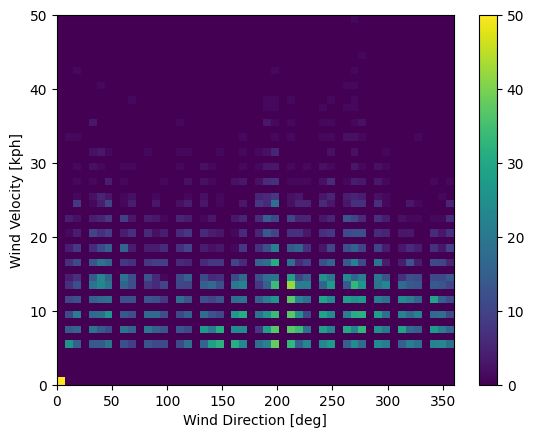

In [1621]:
plt.hist2d(extracted_dataframe_double['Wind_Direction_Degree'], extracted_dataframe_double['Wind_Speed_KilometersPerHour'], bins=(50,50), vmax=50)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [kph]')

In [1622]:
wind_direction_deg = extracted_dataframe_double['Wind_Direction_Degree']
wind_speed_kph = extracted_dataframe_double['Wind_Speed_KilometersPerHour']
wind_direction_rad = wind_direction_deg * np.pi / 180
wind_x_vector = wind_speed_kph * np.cos(wind_direction_rad)
wind_y_vector = wind_speed_kph * np.sin(wind_direction_rad)

Text(0, 0.5, 'Wind Y')

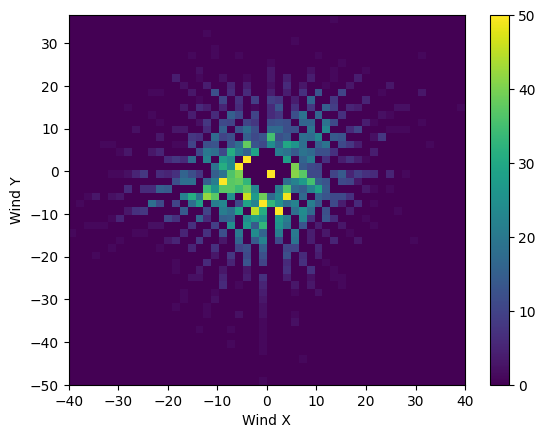

In [1623]:
plt.hist2d(wind_x_vector, wind_y_vector, bins=(50,50), vmax=50)
plt.colorbar()
plt.xlabel('Wind X')
plt.ylabel('Wind Y')

In [1624]:
wind_gusts = extracted_dataframe_double['Wind_Gust_KilometersPerHour']

In [1625]:
wind = [column for column in extracted_dataframe_double.columns if re.search(r'Wind_', column)]
print(wind)
extracted_dataframe_double = extracted_dataframe_double.drop(wind, axis=1)
extracted_dataframe_double.head()

['Wind_Direction_Degree', 'Wind_Direction_Direction', 'Wind_Direction_DirectionShort', 'Wind_Direction_VariableDegreeBegin', 'Wind_Direction_VariableDegreeEnd', 'Wind_Speed_KilometersPerHour', 'Wind_Speed_Condition', 'Wind_Gust_KilometersPerHour']


,Precipitation_Hour_Cm,Precipitation_Snow_Cm,Precipitation_Year_Cm,Precipitation_Month_Cm,Precipitation_Week_Cm,Precipitation_Day_Cm,Precipitation_Year_snow_Cm,Precipitation_Month_snow_Cm,Precipitation_Week_snow_Cm,Precipitation_Day_snow_Cm
0,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0
1,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0
2,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0
3,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0
4,0.0,0,11.28,0.0,3.86,0.0,0,0,0,0


In [1626]:
extracted_dataframe_double['Wind_X'] = wind_x_vector
extracted_dataframe_double['Wind_Y'] = wind_y_vector

In [1627]:
wind_gusts[wind_gusts.isna()] = 0
extracted_dataframe_double['Wind_Gust_KilometersPerHour'] = wind_gusts

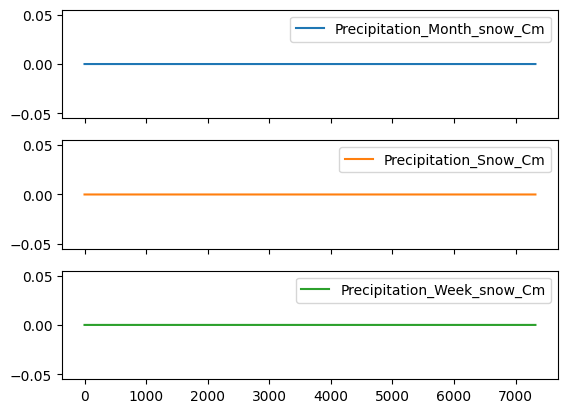

In [1628]:
plot_columns = ['Precipitation_Month_snow_Cm', 'Precipitation_Snow_Cm', 'Precipitation_Week_snow_Cm']
plot_features = extracted_dataframe_double[plot_columns]
_ = plot_features.plot(subplots=True)

In [1629]:
snow_columns = [column for column in extracted_dataframe_double.columns if re.search(r'snow', column, re.IGNORECASE)]
extracted_dataframe_double = extracted_dataframe_double.drop(snow_columns, axis=1)

In [1630]:
extracted_dataframe_double.head()

,Precipitation_Hour_Cm,Precipitation_Year_Cm,Precipitation_Month_Cm,Precipitation_Week_Cm,Precipitation_Day_Cm,Wind_X,Wind_Y,Wind_Gust_KilometersPerHour
0,0.0,11.28,0.0,3.86,0.0,-7.287577,-1.284997,0.0
1,0.0,11.28,0.0,3.86,0.0,-15.491181,-18.461671,42.6
2,0.0,11.28,0.0,3.86,0.0,-21.862732,-3.854990,37.0
3,0.0,11.28,0.0,3.86,0.0,-22.646592,-8.242685,33.3
4,0.0,11.28,0.0,3.86,0.0,-12.817176,-7.400000,0.0


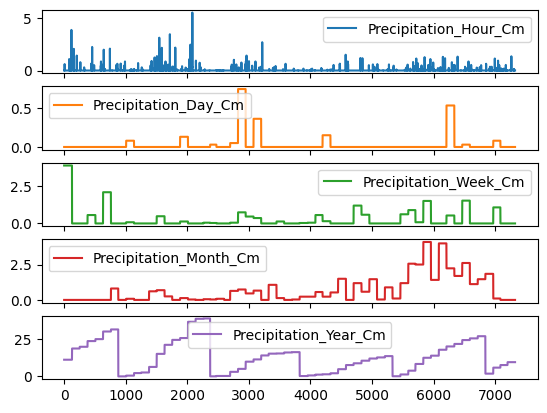

In [1631]:
plot_columns = ['Precipitation_Hour_Cm', 'Precipitation_Day_Cm', 'Precipitation_Week_Cm', 'Precipitation_Month_Cm', 'Precipitation_Year_Cm']
plot_features = extracted_dataframe_double[plot_columns]
_ = plot_features.plot(subplots=True)

Now that all of this data is useable we can continue on back tot the first extraction and see what is happening there.

In [1632]:
extracted_dataframe.head()

,datetime_timezone,datetime_string_local,datetime_iso_8601_local,datetime_is_local_night,datetime_string_utc,datetime_iso_8601_utc,datetime_unix_timestamp,Temperature_Fahrenheit,Temperature_Celsius,Dewpoint_Fahrenheit,...,Windchill_Fahrenheit,Windchill_Celsius,Pressure_Millibar,Pressure_InchesOfMercury,SunInfo_IsSunUp,MoonInfo_Phase,MoonInfo_PhaseName,MoonInfo_Illumination,MoonInfo_Age,MoonInfo_IsMoonUp
0,America/Chicago,20180501055500,2018-05-01T05:55:00-05:00,False,20180501105500,2018-05-01T10:55:00+00:00,1525172100,55,13,37,...,NaN,NaN,1015.92,30.00,True,0.546387,Full Moon,0.978913,16.14,True
1,America/Chicago,20180501115500,2018-05-01T11:55:00-05:00,False,20180501165500,2018-05-01T16:55:00+00:00,1525193700,81,27,52,...,NaN,NaN,1015.58,29.99,True,0.554403,Full Moon,0.971072,16.37,True
2,America/Chicago,20180501175500,2018-05-01T17:55:00-05:00,False,20180501225500,2018-05-01T22:55:00+00:00,1525215300,82,28,48,...,NaN,NaN,1012.87,29.91,True,0.562377,Full Moon,0.962088,16.61,True
3,America/Chicago,20180501235500,2018-05-01T23:55:00-05:00,True,20180502045500,2018-05-02T04:55:00+00:00,1525236900,73,23,52,...,NaN,NaN,1013.89,29.94,False,0.570309,Waning Gibbous,0.951999,16.84,True
4,America/Chicago,20180502055500,2018-05-02T05:55:00-05:00,False,20180502105500,2018-05-02T10:55:00+00:00,1525258500,70,21,52,...,NaN,NaN,1012.87,29.91,True,0.578202,Waning Gibbous,0.940846,17.07,True


In [1633]:
local = [column for column in extracted_dataframe.columns if re.search(r'_local', column)]
timezone = [column for column in extracted_dataframe.columns if re.search(r'_timezone', column)]
fahrenheit = [column for column in extracted_dataframe.columns if re.search(r'_Fahrenheit', column)]
preasure_inches = [column for column in extracted_dataframe.columns if re.search(r'_InchesOfMercury', column)]
print(local)
print(timezone)
print(fahrenheit)
print(preasure_inches)
extracted_dataframe = extracted_dataframe.drop(local, axis=1)
extracted_dataframe = extracted_dataframe.drop(timezone, axis=1)
extracted_dataframe = extracted_dataframe.drop(fahrenheit, axis=1)
extracted_dataframe = extracted_dataframe.drop(preasure_inches, axis=1)
extracted_dataframe = extracted_dataframe.drop('datetime_string_utc', axis=1)
extracted_dataframe.head()

['datetime_string_local', 'datetime_iso_8601_local', 'datetime_is_local_night']
['datetime_timezone']
['Temperature_Fahrenheit', 'Dewpoint_Fahrenheit', 'FeelsLike_Fahrenheit', 'HeatIndex_Fahrenheit', 'Windchill_Fahrenheit']
['Pressure_InchesOfMercury']


,datetime_iso_8601_utc,datetime_unix_timestamp,Temperature_Celsius,Dewpoint_Celsius,FeelsLike_Type,FeelsLike_Celsius,HeatIndex_Celsius,Windchill_Celsius,Pressure_Millibar,SunInfo_IsSunUp,MoonInfo_Phase,MoonInfo_PhaseName,MoonInfo_Illumination,MoonInfo_Age,MoonInfo_IsMoonUp
0,2018-05-01T10:55:00+00:00,1525172100,13,3,None,13,NaN,NaN,1015.92,True,0.546387,Full Moon,0.978913,16.14,True
1,2018-05-01T16:55:00+00:00,1525193700,27,11,None,27,NaN,NaN,1015.58,True,0.554403,Full Moon,0.971072,16.37,True
2,2018-05-01T22:55:00+00:00,1525215300,28,9,None,28,NaN,NaN,1012.87,True,0.562377,Full Moon,0.962088,16.61,True
3,2018-05-02T04:55:00+00:00,1525236900,23,11,None,23,NaN,NaN,1013.89,False,0.570309,Waning Gibbous,0.951999,16.84,True
4,2018-05-02T10:55:00+00:00,1525258500,21,11,None,21,NaN,NaN,1012.87,True,0.578202,Waning Gibbous,0.940846,17.07,True


In [1634]:
for column in extracted_dataframe.columns:
    print(f'Number of NaNs in {column} : {extracted_dataframe[column].isna().sum()}')

Number of NaNs in datetime_iso_8601_utc : 0
Number of NaNs in datetime_unix_timestamp : 0
Number of NaNs in Temperature_Celsius : 0
Number of NaNs in Dewpoint_Celsius : 0
Number of NaNs in FeelsLike_Type : 4454
Number of NaNs in FeelsLike_Celsius : 0
Number of NaNs in HeatIndex_Celsius : 6641
Number of NaNs in Windchill_Celsius : 5137
Number of NaNs in Pressure_Millibar : 15
Number of NaNs in SunInfo_IsSunUp : 0
Number of NaNs in MoonInfo_Phase : 0
Number of NaNs in MoonInfo_PhaseName : 0
Number of NaNs in MoonInfo_Illumination : 0
Number of NaNs in MoonInfo_Age : 0
Number of NaNs in MoonInfo_IsMoonUp : 0


In [1635]:
extracted_dataframe = extracted_dataframe.drop('FeelsLike_Type', axis=1)
extracted_dataframe = extracted_dataframe.drop('HeatIndex_Celsius', axis=1)
extracted_dataframe = extracted_dataframe.drop('Windchill_Celsius', axis=1)
extracted_dataframe = extracted_dataframe.drop('datetime_iso_8601_utc', axis=1)
extracted_dataframe.head()

,datetime_unix_timestamp,Temperature_Celsius,Dewpoint_Celsius,FeelsLike_Celsius,Pressure_Millibar,SunInfo_IsSunUp,MoonInfo_Phase,MoonInfo_PhaseName,MoonInfo_Illumination,MoonInfo_Age,MoonInfo_IsMoonUp
0,1525172100,13,3,13,1015.92,True,0.546387,Full Moon,0.978913,16.14,True
1,1525193700,27,11,27,1015.58,True,0.554403,Full Moon,0.971072,16.37,True
2,1525215300,28,9,28,1012.87,True,0.562377,Full Moon,0.962088,16.61,True
3,1525236900,23,11,23,1013.89,False,0.570309,Waning Gibbous,0.951999,16.84,True
4,1525258500,21,11,21,1012.87,True,0.578202,Waning Gibbous,0.940846,17.07,True


In [1636]:
preasure_capture = extracted_dataframe['Pressure_Millibar'].isna()
extracted_dataframe.loc[preasure_capture, 'Pressure_Millibar'] = 0

In [1637]:
extracted_dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
datetime_unix_timestamp,7324.0,1.604284e+09,4.568133e+07,1.525172e+09,1.564306e+09,1.604761e+09,1.643700e+09,1.683260e+09
Temperature_Celsius,7324.0,1.178058e+01,1.135098e+01,-2.900000e+01,3.000000e+00,1.200000e+01,2.100000e+01,3.600000e+01
Dewpoint_Celsius,7324.0,6.597897e+00,1.061159e+01,-3.400000e+01,-1.000000e+00,6.000000e+00,1.600000e+01,2.800000e+01
FeelsLike_Celsius,7324.0,1.088599e+01,1.298285e+01,-4.200000e+01,1.000000e+00,1.200000e+01,2.100000e+01,4.500000e+01
Pressure_Millibar,7324.0,1.014728e+03,4.652152e+01,0.000000e+00,1.012530e+03,1.016600e+03,1.021340e+03,1.044700e+03
MoonInfo_Phase,7324.0,4.999218e-01,2.883863e-01,1.758595e-04,2.504104e-01,4.995633e-01,7.492804e-01,9.999337e-01
MoonInfo_Illumination,7324.0,4.999698e-01,3.522541e-01,4.335436e-08,1.490625e-01,5.019891e-01,8.500230e-01,1.000000e+00
MoonInfo_Age,7324.0,1.476297e+01,8.516311e+00,1.000000e-02,7.397500e+00,1.475000e+01,2.213000e+01,2.953000e+01


Both of the extracted information is pulled out and sifted through.  We can move back to the string df and finish up dropping specific data that is either the same as data already available in a better format.

In [1638]:
data_string_like.head()

,ObservedAt_DateTime,Station,Record,CurrentConditions,CurrentConditionsAbbreviation,ConditionType,CloudCondition,CloudReport,raw
0,5/1/2018 5:55,KJOT,011055Z AUTO 19004KT 10SM CLR 13/03 A3000 RMK ...,Clear Skies,NaN,Clear,Clear Skies,Clear Skies,AUTO 19004KT 10SM CLR 13/03 A3000 RMK AO2 T013...
1,5/1/2018 11:55,KJOT,011655Z AUTO 23013G23KT 10SM SCT065 27/11 A299...,Scattered,NaN,Cloudy,Scattered,Scattered,AUTO 23013G23KT 10SM SCT065 27/11 A2999 RMK AO...
2,5/1/2018 17:55,KJOT,012255Z AUTO 19012G20KT 10SM CLR 28/09 A2991 R...,Clear Skies,NaN,Clear,Clear Skies,Clear Skies,AUTO 19012G20KT 10SM CLR 28/09 A2991 RMK AO2 T...
3,5/1/2018 23:55,KJOT,020455Z AUTO 20013G18KT 10SM CLR 23/11 A2994 R...,Clear Skies,NaN,Clear,Clear Skies,Clear Skies,AUTO 20013G18KT 10SM CLR 23/11 A2994 RMK AO2 T...
4,5/2/2018 5:55,KJOT,021055Z AUTO 21008KT 10SM CLR 21/11 A2991 RMK ...,Clear Skies,NaN,Clear,Clear Skies,Clear Skies,AUTO 21008KT 10SM CLR 21/11 A2991 RMK AO2 T020...


Quick note 
    
    CurrentConditions -> Enum
    Drop CurrentConditionsAbbeviation / match NaN to CurrentConditions

In [1639]:
abbrevuation_nan = data_string_like['CurrentConditionsAbbreviation'].isna()
data_string_like.loc[abbrevuation_nan, 'CurrentConditionsAbbreviation'] = 'Clear Skies'
cca = data_string_like['CurrentConditionsAbbreviation']
cc = data_string_like['CurrentConditions']
matches_map = cc != cca
data_string_like.loc[matches_map, ['CurrentConditions', 'CurrentConditionsAbbreviation']]

C:\Users\turne\AppData\Local\Temp\ipykernel_20656\891507411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_string_like.loc[abbrevuation_nan, 'CurrentConditionsAbbreviation'] = 'Clear Skies'


,CurrentConditions,CurrentConditionsAbbreviation
1,Scattered,Clear Skies
6,"In The Vicinity, Thunderstorms",VCTS
7,Scattered,Clear Skies
8,Scattered,Clear Skies
9,Overcast Sky,Clear Skies
...,...,...
7311,Scattered,Clear Skies
7312,Overcast Sky,Clear Skies
7313,Overcast Sky,Clear Skies
7314,Broken Sky,Clear Skies


In [1640]:
data_string_like['CurrentConditions'].isna().sum()


0

In [1641]:
data_string_like = data_string_like.drop(['CurrentConditionsAbbreviation'], axis=1)

In [1642]:
data_string_like.head()

,ObservedAt_DateTime,Station,Record,CurrentConditions,ConditionType,CloudCondition,CloudReport,raw
0,5/1/2018 5:55,KJOT,011055Z AUTO 19004KT 10SM CLR 13/03 A3000 RMK ...,Clear Skies,Clear,Clear Skies,Clear Skies,AUTO 19004KT 10SM CLR 13/03 A3000 RMK AO2 T013...
1,5/1/2018 11:55,KJOT,011655Z AUTO 23013G23KT 10SM SCT065 27/11 A299...,Scattered,Cloudy,Scattered,Scattered,AUTO 23013G23KT 10SM SCT065 27/11 A2999 RMK AO...
2,5/1/2018 17:55,KJOT,012255Z AUTO 19012G20KT 10SM CLR 28/09 A2991 R...,Clear Skies,Clear,Clear Skies,Clear Skies,AUTO 19012G20KT 10SM CLR 28/09 A2991 RMK AO2 T...
3,5/1/2018 23:55,KJOT,020455Z AUTO 20013G18KT 10SM CLR 23/11 A2994 R...,Clear Skies,Clear,Clear Skies,Clear Skies,AUTO 20013G18KT 10SM CLR 23/11 A2994 RMK AO2 T...
4,5/2/2018 5:55,KJOT,021055Z AUTO 21008KT 10SM CLR 21/11 A2991 RMK ...,Clear Skies,Clear,Clear Skies,Clear Skies,AUTO 21008KT 10SM CLR 21/11 A2991 RMK AO2 T020...


In [1643]:
data_string_like = data_string_like.drop(['Record', 'raw'], axis=1)

In [1644]:
data_string_like.head()

,ObservedAt_DateTime,Station,CurrentConditions,ConditionType,CloudCondition,CloudReport
0,5/1/2018 5:55,KJOT,Clear Skies,Clear,Clear Skies,Clear Skies
1,5/1/2018 11:55,KJOT,Scattered,Cloudy,Scattered,Scattered
2,5/1/2018 17:55,KJOT,Clear Skies,Clear,Clear Skies,Clear Skies
3,5/1/2018 23:55,KJOT,Clear Skies,Clear,Clear Skies,Clear Skies
4,5/2/2018 5:55,KJOT,Clear Skies,Clear,Clear Skies,Clear Skies


In [1645]:
print(data_string_like['Station'].isna().sum())
print(data_string_like['Station'].value_counts())
data_string_like = data_string_like.drop(['Station'], axis=1) # no extra information

0
KJOT    7324
Name: Station, dtype: int64


In [1646]:
print(data_string_like['ConditionType'].isna().sum())
print(data_string_like['ConditionType'].value_counts())
data_string_like = data_string_like.drop(['ConditionType'], axis=1) # held by CurrentConditions / only a single "Rain" condition

0
Cloudy    3798
Clear     3525
Rain         1
Name: ConditionType, dtype: int64


In [1647]:
data_string_like.head()

,ObservedAt_DateTime,CurrentConditions,CloudCondition,CloudReport
0,5/1/2018 5:55,Clear Skies,Clear Skies,Clear Skies
1,5/1/2018 11:55,Scattered,Scattered,Scattered
2,5/1/2018 17:55,Clear Skies,Clear Skies,Clear Skies
3,5/1/2018 23:55,Clear Skies,Clear Skies,Clear Skies
4,5/2/2018 5:55,Clear Skies,Clear Skies,Clear Skies


In [1648]:
print(data_string_like['CloudCondition'].isna().sum())
print(data_string_like['CloudReport'].isna().sum())

0
0


In [1649]:
print(data_string_like['CloudCondition'].value_counts().shape)
print()
print(data_string_like['CloudReport'].value_counts().shape)

(101,)

(11,)


In [1650]:
data_string_like = data_string_like.drop(['CloudCondition'], axis=1)

Either of these could be used in the model.  I will use the 'CloudReport' for this assignment, later this could become a varaible in the search optimization.

In [1651]:
# extracted_dataframe = extracted_dataframe.drop('FeelsLike_Type', axis=1)
# extracted_dataframe = extracted_dataframe.drop('HeatIndex_Celsius', axis=1)
# extracted_dataframe = extracted_dataframe.drop('Windchill_Celsius', axis=1)
# extracted_dataframe = extracted_dataframe.drop('datetime_iso_8601_utc', axis=1)
# extracted_dataframe.head()

In [1652]:
combined_dataframe = pd.concat([
    quickly_availble_data,
    data_string_like,
    extracted_dataframe,
    extracted_dataframe_double],
    axis=1)

In [1653]:
combined_dataframe.head()

,ObservedAt,ID,RelativeHumidity,daily_total_precipitation,ObservedAt_DateTime,CurrentConditions,CloudReport,datetime_unix_timestamp,Temperature_Celsius,Dewpoint_Celsius,...,MoonInfo_Age,MoonInfo_IsMoonUp,Precipitation_Hour_Cm,Precipitation_Year_Cm,Precipitation_Month_Cm,Precipitation_Week_Cm,Precipitation_Day_Cm,Wind_X,Wind_Y,Wind_Gust_KilometersPerHour
0,1525172100,220160752,0.509,NaN,5/1/2018 5:55,Clear Skies,Clear Skies,1525172100,13,3,...,16.14,True,0.0,11.28,0.0,3.86,0.0,-7.287577,-1.284997,0.0
1,1525193700,220215015,0.368,NaN,5/1/2018 11:55,Scattered,Scattered,1525193700,27,11,...,16.37,True,0.0,11.28,0.0,3.86,0.0,-15.491181,-18.461671,42.6
2,1525215300,220262557,0.303,NaN,5/1/2018 17:55,Clear Skies,Clear Skies,1525215300,28,9,...,16.61,True,0.0,11.28,0.0,3.86,0.0,-21.862732,-3.854990,37.0
3,1525236900,220311850,0.468,NaN,5/1/2018 23:55,Clear Skies,Clear Skies,1525236900,23,11,...,16.84,True,0.0,11.28,0.0,3.86,0.0,-22.646592,-8.242685,33.3
4,1525258500,220363232,0.530,NaN,5/2/2018 5:55,Clear Skies,Clear Skies,1525258500,21,11,...,17.07,True,0.0,11.28,0.0,3.86,0.0,-12.817176,-7.400000,0.0


In [1654]:
for column in combined_dataframe.columns:
    print(f'Number of NaNs in {column} : {combined_dataframe[column].isna().sum()}')

Number of NaNs in ObservedAt : 0
Number of NaNs in ID : 0
Number of NaNs in RelativeHumidity : 0
Number of NaNs in daily_total_precipitation : 7324
Number of NaNs in ObservedAt_DateTime : 0
Number of NaNs in CurrentConditions : 0
Number of NaNs in CloudReport : 0
Number of NaNs in datetime_unix_timestamp : 0
Number of NaNs in Temperature_Celsius : 0
Number of NaNs in Dewpoint_Celsius : 0
Number of NaNs in FeelsLike_Celsius : 0
Number of NaNs in Pressure_Millibar : 0
Number of NaNs in SunInfo_IsSunUp : 0
Number of NaNs in MoonInfo_Phase : 0
Number of NaNs in MoonInfo_PhaseName : 0
Number of NaNs in MoonInfo_Illumination : 0
Number of NaNs in MoonInfo_Age : 0
Number of NaNs in MoonInfo_IsMoonUp : 0
Number of NaNs in Precipitation_Hour_Cm : 0
Number of NaNs in Precipitation_Year_Cm : 0
Number of NaNs in Precipitation_Month_Cm : 0
Number of NaNs in Precipitation_Week_Cm : 0
Number of NaNs in Precipitation_Day_Cm : 0
Number of NaNs in Wind_X : 0
Number of NaNs in Wind_Y : 0
Number of NaNs i

In [1655]:
combined_dataframe = combined_dataframe.drop(['daily_total_precipitation'], axis=1)

In [1656]:
for column in combined_dataframe.columns:
    print(f'Number of NaNs in {column} : {combined_dataframe[column].isna().sum()}')

Number of NaNs in ObservedAt : 0
Number of NaNs in ID : 0
Number of NaNs in RelativeHumidity : 0
Number of NaNs in ObservedAt_DateTime : 0
Number of NaNs in CurrentConditions : 0
Number of NaNs in CloudReport : 0
Number of NaNs in datetime_unix_timestamp : 0
Number of NaNs in Temperature_Celsius : 0
Number of NaNs in Dewpoint_Celsius : 0
Number of NaNs in FeelsLike_Celsius : 0
Number of NaNs in Pressure_Millibar : 0
Number of NaNs in SunInfo_IsSunUp : 0
Number of NaNs in MoonInfo_Phase : 0
Number of NaNs in MoonInfo_PhaseName : 0
Number of NaNs in MoonInfo_Illumination : 0
Number of NaNs in MoonInfo_Age : 0
Number of NaNs in MoonInfo_IsMoonUp : 0
Number of NaNs in Precipitation_Hour_Cm : 0
Number of NaNs in Precipitation_Year_Cm : 0
Number of NaNs in Precipitation_Month_Cm : 0
Number of NaNs in Precipitation_Week_Cm : 0
Number of NaNs in Precipitation_Day_Cm : 0
Number of NaNs in Wind_X : 0
Number of NaNs in Wind_Y : 0
Number of NaNs in Wind_Gust_KilometersPerHour : 0


In [1657]:
combined_dataframe[['ObservedAt', 'ObservedAt_DateTime', 'datetime_unix_timestamp']].head()

,ObservedAt,ObservedAt_DateTime,datetime_unix_timestamp
0,1525172100,5/1/2018 5:55,1525172100
1,1525193700,5/1/2018 11:55,1525193700
2,1525215300,5/1/2018 17:55,1525215300
3,1525236900,5/1/2018 23:55,1525236900
4,1525258500,5/2/2018 5:55,1525258500


In [1658]:
datetime = pd.to_datetime(combined_dataframe['ObservedAt_DateTime'], format='%m/%d/%Y %H:%M')

In [1659]:
combined_dataframe = combined_dataframe.drop(['ObservedAt', 'ObservedAt_DateTime', 'datetime_unix_timestamp'], axis=1)

In [1660]:
combined_dataframe = combined_dataframe.drop(['ID'], axis=1)

In [1661]:
combined_dataframe['datetime'] = datetime

In [1662]:
combined_dataframe.head()

,RelativeHumidity,CurrentConditions,CloudReport,Temperature_Celsius,Dewpoint_Celsius,FeelsLike_Celsius,Pressure_Millibar,SunInfo_IsSunUp,MoonInfo_Phase,MoonInfo_PhaseName,...,MoonInfo_IsMoonUp,Precipitation_Hour_Cm,Precipitation_Year_Cm,Precipitation_Month_Cm,Precipitation_Week_Cm,Precipitation_Day_Cm,Wind_X,Wind_Y,Wind_Gust_KilometersPerHour,datetime
0,0.509,Clear Skies,Clear Skies,13,3,13,1015.92,True,0.546387,Full Moon,...,True,0.0,11.28,0.0,3.86,0.0,-7.287577,-1.284997,0.0,2018-05-01 05:55:00
1,0.368,Scattered,Scattered,27,11,27,1015.58,True,0.554403,Full Moon,...,True,0.0,11.28,0.0,3.86,0.0,-15.491181,-18.461671,42.6,2018-05-01 11:55:00
2,0.303,Clear Skies,Clear Skies,28,9,28,1012.87,True,0.562377,Full Moon,...,True,0.0,11.28,0.0,3.86,0.0,-21.862732,-3.854990,37.0,2018-05-01 17:55:00
3,0.468,Clear Skies,Clear Skies,23,11,23,1013.89,False,0.570309,Waning Gibbous,...,True,0.0,11.28,0.0,3.86,0.0,-22.646592,-8.242685,33.3,2018-05-01 23:55:00
4,0.530,Clear Skies,Clear Skies,21,11,21,1012.87,True,0.578202,Waning Gibbous,...,True,0.0,11.28,0.0,3.86,0.0,-12.817176,-7.400000,0.0,2018-05-02 05:55:00


In [1663]:
combined_dataframe['CloudReport'].value_counts()

Clear Skies                              3475
Overcast Sky                             1636
Scattered                                 711
Broken Sky / Overcast Sky                 433
Broken Sky                                355
Scattered / Overcast Sky                  286
Scattered / Broken Sky / Overcast Sky     197
Scattered / Broken Sky                    177
Vertical Visibility                        51
Broken Sky / Scattered / Overcast Sky       2
Broken Sky / Scattered                      1
Name: CloudReport, dtype: int64

In [1664]:
combined_dataframe['CurrentConditions'].value_counts()

Clear Skies                             3335
Overcast Sky                            1176
Scattered                               1112
Broken Sky                               615
Mist                                     398
Light Rain                               181
Rain                                     122
Light Snow                               119
Light Drizzle                             60
Drizzle                                   49
Fog                                       42
Strong Rain                               33
Haze                                      15
In The Vicinity, Thunderstorms            13
/ Overcast Sky                            10
Freezing, Fog                              7
Snow                                       7
Light Thunderstorms, Rain                  5
Thunderstorms                              5
Strong Thunderstorms, Rain                 4
Thunderstorms, Rain                        4
Dry                                        3
/ Broken S

In [1665]:
combined_dataframe = combined_dataframe.drop(['CloudReport'], axis=1)

We still have a few things to drop and a new index to make but now we need to find what information would be usful to have.

With the predicted label at the beginning of this not having any values the first thing to do is figure out what will be a usable label.

For now Let's use the temperature in celsius as a label for thought.

In [1666]:
combined_dataframe.to_csv('first_look_data.csv', index=False)